<a href="https://colab.research.google.com/github/highstreeto/akt-image-class-fh-uni/blob/master/ImageClass_FH_Uni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Needed locally

In [0]:
!pip install sklearn

Upgrade matplotlib so bug with seaborn is fixed

In [0]:
!pip install --upgrade matplotlib

     |████████████████████████████████| 13.1MB 184kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1


In [0]:
%load_ext tensorboard

import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import random
import os
import sklearn.metrics as metrics
import seaborn as sn
import pandas as pd

## Download Images

The download is documentetd here.

The images are loaded via GitHub so the same images are used.

### Install Google Image Downloader
Useful for when using Google Collabratory

In [0]:
!pip install google_images_download

### Download

* Keywords are: `fh gebaeude oesterreich` and `universitaet gebaeude oesterreich`
* Umlaute are not recognized by downloader so use ae, etc. instead

In [0]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()
fh_images = response.download({"keywords": "fh gebaeude oesterreich", "output_directory": "drive/My Drive/AKT"})

SyntaxError: ignored

In [0]:
uni_images = response.download({"keywords": "universitaet gebaeude oesterreich", "output_directory": "drive/My Drive/AKT"})


Item no.: 1 --> Item name = universitaet gebaeude oesterreich
Evaluating...
Starting Download...
Completed Image ====> 1.1200px-Wien_-_Universit%C3%A4t_%283%29.JPG
URLError on an image...trying next one... Error: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)>
Completed Image ====> 2.UniWien.jpg
Completed Image ====> 3.Technische_Universit%C3%A4t_Wien_mainbuilding_mainentrance_northview_.jpg
Completed Image ====> 4.Universit%C3%A4t_Geb%C3%A4ude.jpg
Completed Image ====> 5.gebaude-der-bibliothek-der-tu-wien-universitat-in-wien-osterreich-mkhmjx.jpg
Completed Image ====> 6.technische-universitat-tu-wien-gebaude-in-wien-osterreich-mkhmjt.jpg
URLError on an image...trying next one... Error: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)>
URLError on an image...trying next one... Error: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)>
Completed Image ====> 7.Fakult%C3%A4t_

## Import images from GitHub


In [0]:
!git clone -l -s https://github.com/highstreeto/akt-image-class-fh-uni.git data
!ls data

In [0]:
%cd data
!git pull
%cd ..

# Training Data

## Functions

In [0]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

def plotImages(images_arr, size):
    fig, axes = plt.subplots(1, size, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
  
def class_idx_to_name(class_idx):
    if (class_idx == 0):
      return "FH"
    else:
      return "Uni"

## ImageDataGenerator
* Do not use vertical flip, as up-side down buildings make no sense

In [0]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
	rescale=1./255,
	rotation_range=25,
	width_shift_range=0.1,
	height_shift_range=0.1,
	brightness_range=(0.9, 1.1),
	horizontal_flip=True,
	vertical_flip=False,
	validation_split=.3
)

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
		rescale=1./255,
)

In [0]:
if os.path.isdir("./data"):
	train_dir = "./data/train/"
	test_dir = "./data/test/"
else:
	train_dir = "./train/"
	test_dir = "./test/"

IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

train_data_gen = train_image_generator.flow_from_directory(
	batch_size=batch_size,
	directory=train_dir,
	shuffle=True,
	target_size=(IMG_HEIGHT, IMG_WIDTH),
	subset="training"
)

validation_data_gen = train_image_generator.flow_from_directory(
	batch_size=batch_size,
	directory=train_dir,
	shuffle=True,
	target_size=(IMG_HEIGHT, IMG_WIDTH),
	subset="validation"
)

test_data_gen = test_image_generator.flow_from_directory(
	batch_size=batch_size,
  directory=test_dir,
  target_size=(IMG_HEIGHT, IMG_WIDTH)
)

print(train_data_gen.class_indices)
print(validation_data_gen.class_indices)
print(test_data_gen.class_indices)

Found 129 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
{'fh gebaeude oesterreich': 0, 'universitaet gebaeude oesterreich': 1}
{'fh gebaeude oesterreich': 0, 'universitaet gebaeude oesterreich': 1}
{'fh gebaeude oesterreich': 0, 'universitaet gebaeude oesterreich': 1}


## Exmaple images

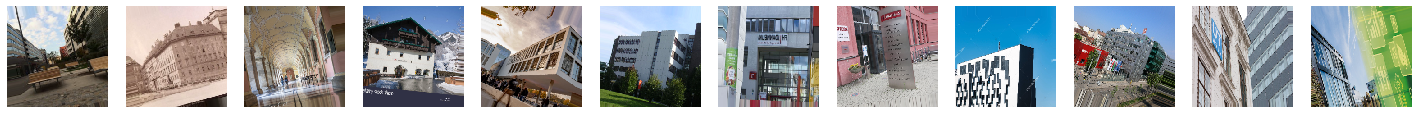

In [0]:
plotImages(next(skip_broken_images(train_data_gen))[0], 12)

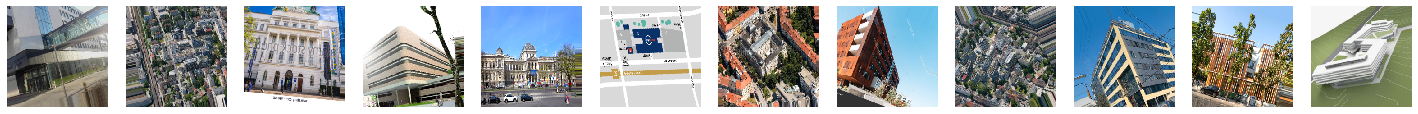

In [0]:
plotImages(next(skip_broken_images(validation_data_gen))[0], 12)

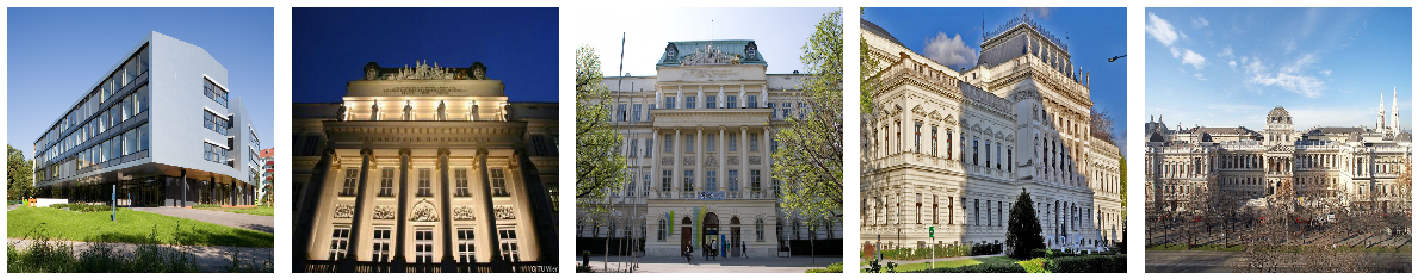

In [0]:
plotImages(next(skip_broken_images(test_data_gen))[0], 5)

# Callbacks / Functions

In [0]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
		monitor="val_loss",
		mode="min",
		min_delta=0.5,
		patience=6,
		verbose=1
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
		log_dir = './tb',
		batch_size = batch_size
)

In [0]:
def best_model_checkpoint(filepath):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath=filepath,
      monitor="val_categorical_accuracy",
      save_best_only=True,
      verbose=1
  )

In [0]:
def test_model(model):
  y_pred = model_dense.predict_generator(test_data_gen, steps=test_data_gen.samples / batch_size)
  y_pred = np.argmax(y_pred, axis=1)

  y_true = test_data_gen.classes

  c_matrix = metrics.confusion_matrix(y_true, y_pred)
  plt.figure()
  sn.set()
  sn.heatmap(c_matrix, annot=True)
  plt.title("TN: Upper left, TP: Lower right, FN: Lower left, FP: Upper right")
  plt.show()

  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
  auc = metrics.auc(fpr, tpr)

  plt.figure(2)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

# Network ResNet50V2

In [113]:
base_model_res50 = tf.keras.applications.resnet_v2.ResNet50V2(
	include_top=False,
	pooling='max',
	input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
	weights='imagenet')

model_res50 = tf.keras.Sequential([
	base_model_res50,
	tf.keras.layers.Dense(512, 'relu'),
	tf.keras.layers.Dense(256, 'relu'),
	tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])

for layer in base_model_res50.layers:
	layer.trainable = False

model_res50.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_33 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_34 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 514       
Total params: 24,745,730
Trainable params: 1,180,930
Non-trainable params: 23,564,800
_________________________________________________________________


## Training
* Train only last layer to preserve learned weights (buildings should be known by ResNet)
* Use 3 steps per epoch as we have a batch size of 32 and ~100 images per class (images / batch size)
* Use EarlyStoppingCallback to stop learning
* TensorBoard is very slow when used in Google Collab.

In [115]:
model_res50.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['categorical_accuracy'])

# !rm -rf "./tb"
# %tensorboard --logdir "./tb"

history_res50 = model_res50.fit_generator(
	skip_broken_images(train_data_gen),
	steps_per_epoch=train_data_gen.samples // batch_size,
	epochs=30,
	validation_data=skip_broken_images(validation_data_gen),
	validation_steps=validation_data_gen.samples // batch_size,
	callbacks=[early_stopping_callback, best_model_checkpoint("./model_res50.h5")]
#	callbacks=[early_stopping_callback, tensorboard_callback]
)

Epoch 1/30
1/4 [======>.......................] - ETA: 1:25 - loss: 22.8953 - categorical_accuracy: 0.5000
Epoch 00001: val_categorical_accuracy improved from -inf to 0.50000, saving model to ./model_res50.h5
4/4 [==============================] - 124s 31s/step - loss: 15.6354 - categorical_accuracy: 0.5303 - val_loss: 22.8953 - val_categorical_accuracy: 0.5000
Epoch 2/30
1/4 [======>.......................] - ETA: 22s - loss: 3.5614 - categorical_accuracy: 0.5455
Epoch 00002: val_categorical_accuracy improved from 0.50000 to 0.54545, saving model to ./model_res50.h5
4/4 [==============================] - 35s 9s/step - loss: 15.9125 - categorical_accuracy: 0.5052 - val_loss: 3.5614 - val_categorical_accuracy: 0.5455
Epoch 3/30
1/4 [======>.......................] - ETA: 22s - loss: 3.2685 - categorical_accuracy: 0.5909
Epoch 00003: val_categorical_accuracy improved from 0.54545 to 0.59091, saving model to ./model_res50.h5
4/4 [==============================] - 43s 11s/step - loss: 3.86

**Display loss and accuracy**

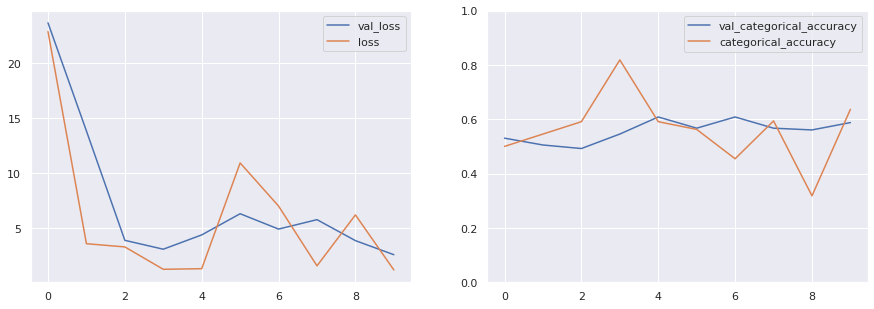

In [121]:
plt.figure(figsize=(15,5))
plt.subplot(1,2, 1)
plt.plot(history_res50.history['loss'])
plt.plot(history_res50.history['val_loss'])
plt.legend(['val_loss', 'loss'])

plt.subplot(1,2, 2)
plt.plot(history_res50.history['categorical_accuracy'], scaley=False)
plt.plot(history_res50.history['val_categorical_accuracy'], scaley=False)
plt.legend(['val_categorical_accuracy', 'categorical_accuracy'])

## Evaluate

**Load model**

In [0]:
model_res50 = tf.keras.models.load_model("./model_res50.h5")

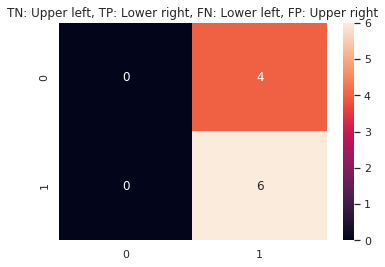

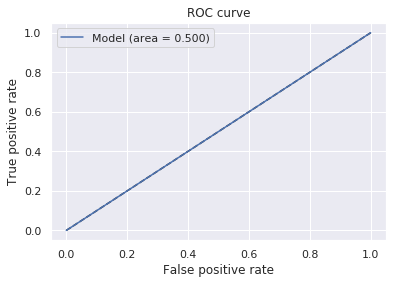

In [122]:
test_model(model_res50)

## Test with one batch from training

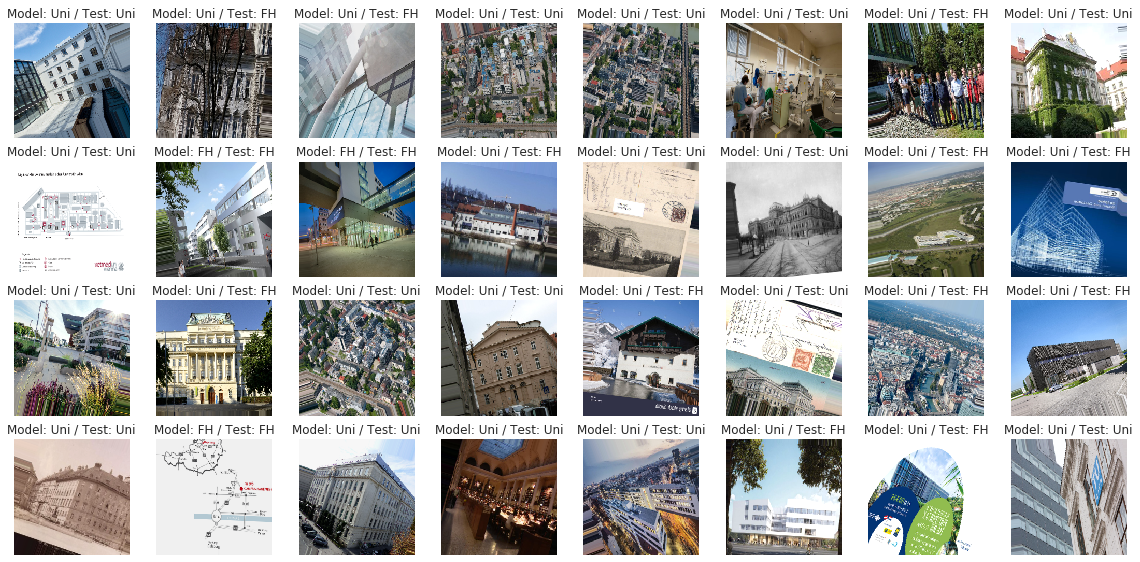

In [0]:
plt.figure(figsize=(20,20))
batch = next(skip_broken_images(train_data_gen))
for i, img in enumerate(batch[0]):
  # ResNet takes natches of images to classify so create new batch array with one image
  model_input = np.zeros((1, 224, 224, 3), dtype=float)
  model_input[0] = img

  pred = np.argmax(model_res50.predict(model_input)[0])
  test = np.argmax(batch[1][i])

  plt.subplot(8,8, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title("Model: %s / Test: %s" % (class_idx_to_name(pred), class_idx_to_name(test)))

## Observations

* Without validation, over-fitting is easily achived
* Model picks something up, but can't really seperate FH and Uni buildings
* Possible reasons
  * Training data contains weird images (signs, brochures, etc.)
  * ImageNet just sees buildings not old or new (needed for seperation between FH and Uni)

# Network DenseNet201

In [59]:
base_model_dense = tf.keras.applications.densenet.DenseNet201(
	include_top=False,
	pooling='max',
	input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
	weights='imagenet')

model_dense = tf.keras.Sequential([
	base_model_dense,
	tf.keras.layers.Dense(512, 'relu'),
	tf.keras.layers.Dense(256, 'relu'),
	tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])

for layer in base_model_dense.layers:
	layer.trainable = False

model_dense.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
dense_21 (Dense)             (None, 512)               983552    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 514       
Total params: 19,437,378
Trainable params: 1,115,394
Non-trainable params: 18,321,984
_________________________________________________________________


## Training

In [60]:
model_dense.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['categorical_accuracy'])

# !rm -rf "./tb"
# %tensorboard --logdir "./tb"

history_dense = model_dense.fit_generator(
	skip_broken_images(train_data_gen),
	steps_per_epoch=train_data_gen.samples // batch_size,
	epochs=30,
	validation_data=skip_broken_images(validation_data_gen),
	validation_steps=validation_data_gen.samples // batch_size,
	callbacks=[early_stopping_callback, best_model_checkpoint("./model_dense.h5")]
#	callbacks=[early_stopping_callback, tensorboard_callback]
)

Epoch 1/30
3/3 [==============================] - 56s 19s/step - loss: 6.0401 - categorical_accuracy: 0.5538
Epoch 2/30
3/3 [==============================] - 33s 11s/step - loss: 7.4943 - categorical_accuracy: 0.5231
Epoch 3/30
3/3 [==============================] - 34s 11s/step - loss: 1.4160 - categorical_accuracy: 0.5077
Epoch 4/30
3/3 [==============================] - 33s 11s/step - loss: 3.6053 - categorical_accuracy: 0.5077
Epoch 5/30
3/3 [==============================] - 31s 10s/step - loss: 2.1326 - categorical_accuracy: 0.4615
Epoch 6/30
3/3 [==============================] - 32s 11s/step - loss: 2.5835 - categorical_accuracy: 0.4769
Epoch 7/30
3/3 [==============================] - 33s 11s/step - loss: 1.8780 - categorical_accuracy: 0.4769
Epoch 8/30
3/3 [==============================] - 33s 11s/step - loss: 2.4758 - categorical_accuracy: 0.5231
Epoch 9/30
3/3 [==============================] - 34s 11s/step - loss: 0.6514 - categorical_accuracy: 0.6923
Epoch 10/30
3/3 [==

**Display loss and accuracy**

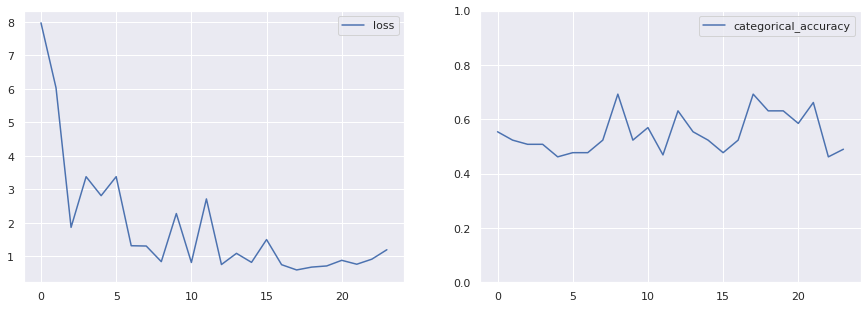

In [61]:
plt.figure(figsize=(15,5))
plt.subplot(1,2, 1)
plt.plot(history_dense.history['loss'])
plt.legend(['loss'])

plt.subplot(1,2, 2)
plt.plot(history_dense.history['categorical_accuracy'], scaley=False)
plt.legend(['categorical_accuracy'])

## Evaluate

**Load model**

In [0]:
model_dense = tf.keras.models.load_model("./model_dense.h5")

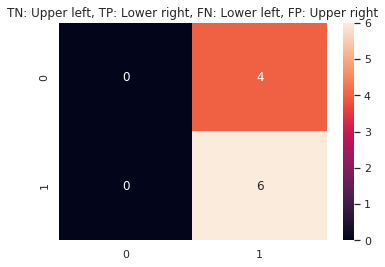

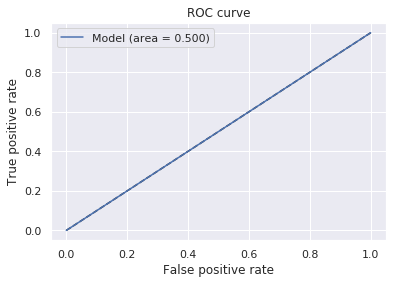

In [75]:
test_model(model_dense)

## Test with one batch from training

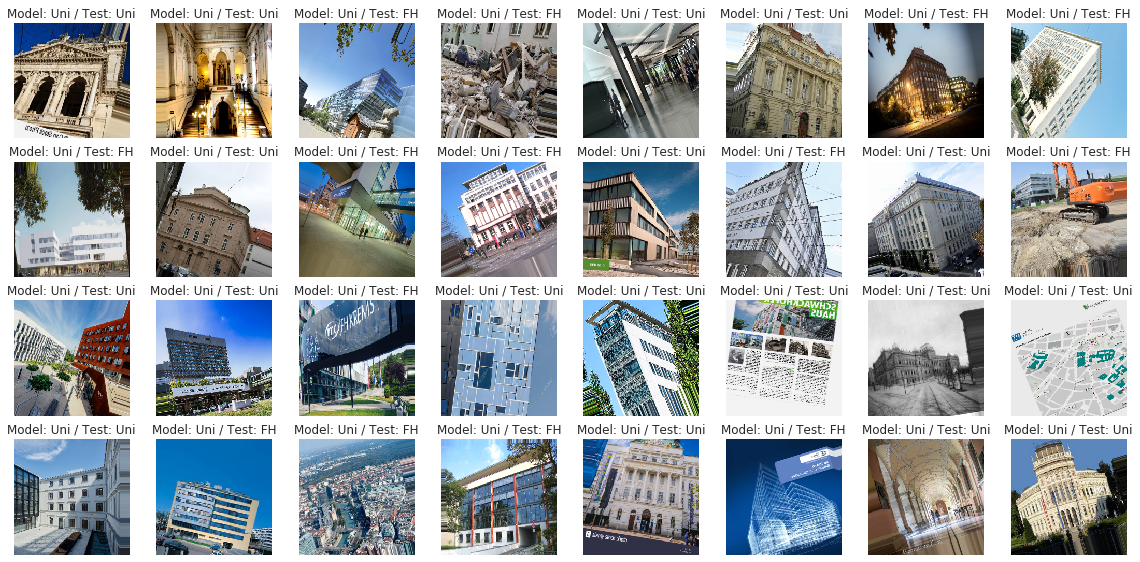

In [79]:
plt.figure(figsize=(20,20))
batch = next(skip_broken_images(train_data_gen))
for i, img in enumerate(batch[0]):
  # ResNet takes natches of images to classify so create new batch array with one image
  model_input = np.zeros((1, 224, 224, 3), dtype=float)
  model_input[0] = img

  pred = np.argmax(model_dense.predict(model_input)[0])
  test = np.argmax(batch[1][i])

  plt.subplot(8,8, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title("Model: %s / Test: %s" % (class_idx_to_name(pred), class_idx_to_name(test)))

## Observations

# Network InceptionV3

In [80]:
base_model_inc = tf.keras.applications.inception_v3.InceptionV3(
	include_top=False,
	pooling='max',
	input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
	weights='imagenet')

model_inc = tf.keras.Sequential([
	base_model_inc,
	tf.keras.layers.Dense(512, 'relu'),
	tf.keras.layers.Dense(256, 'relu'),
	tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])

for layer in base_model_inc.layers:
	layer.trainable = False

model_inc.summary()

87916544/87910968 [==============================] - 3s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_24 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 514       
Total params: 22,983,714
Trainable params: 1,180,930
Non-trainable params: 21,802,784
_________________________________________________________________


## Training

In [90]:
model_inc.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['categorical_accuracy'])

# !rm -rf "./tb"
# %tensorboard --logdir "./tb"

history_inc = model_inc.fit_generator(
	skip_broken_images(train_data_gen),
	steps_per_epoch=train_data_gen.samples // batch_size,
	epochs=30,
	validation_data=skip_broken_images(validation_data_gen),
	validation_steps=validation_data_gen.samples // batch_size,
	callbacks=[early_stopping_callback, best_model_checkpoint("./model_inc.h5")]
#	callbacks=[early_stopping_callback, tensorboard_callback]
)

Epoch 1/30
2/3 [===================>..........] - ETA: 13s - loss: 0.4672 - categorical_accuracy: 0.5455
Epoch 00001: categorical_accuracy improved from -inf to 0.46154, saving model to ./model_inc.h5
3/3 [==============================] - 64s 21s/step - loss: 3.4200 - categorical_accuracy: 0.4615
Epoch 2/30
2/3 [===================>..........] - ETA: 6s - loss: 2.1226 - categorical_accuracy: 0.5469 
Epoch 00002: categorical_accuracy improved from 0.46154 to 0.55385, saving model to ./model_inc.h5
3/3 [==============================] - 14s 5s/step - loss: 1.5840 - categorical_accuracy: 0.5538
Epoch 3/30
2/3 [===================>..........] - ETA: 6s - loss: 4.6359 - categorical_accuracy: 0.5312 
Epoch 00003: categorical_accuracy did not improve from 0.55385
3/3 [==============================] - 13s 4s/step - loss: 5.9846 - categorical_accuracy: 0.5231
Epoch 4/30
2/3 [===================>..........] - ETA: 6s - loss: 1.2117 - categorical_accuracy: 0.5781 
Epoch 00004: categorical_accur

**Display loss and accuracy**

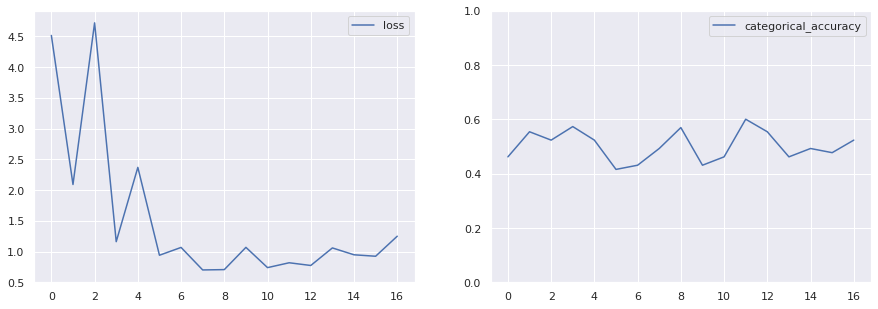

In [91]:
plt.figure(figsize=(15,5))
plt.subplot(1,2, 1)
plt.plot(history_inc.history['loss'])
plt.legend(['loss'])

plt.subplot(1,2, 2)
plt.plot(history_inc.history['categorical_accuracy'], scaley=False)
plt.legend(['categorical_accuracy'])

## Evaluate

**Load model**

In [0]:
model_inc = tf.keras.models.load_model("./model_inc.h5")

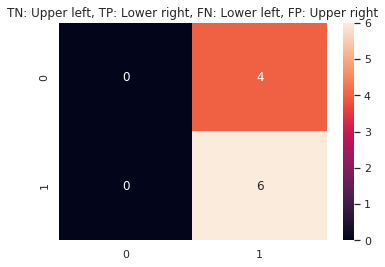

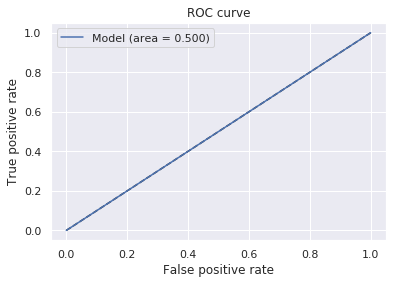

In [93]:
test_model(model_inc)

## Test with one batch from training

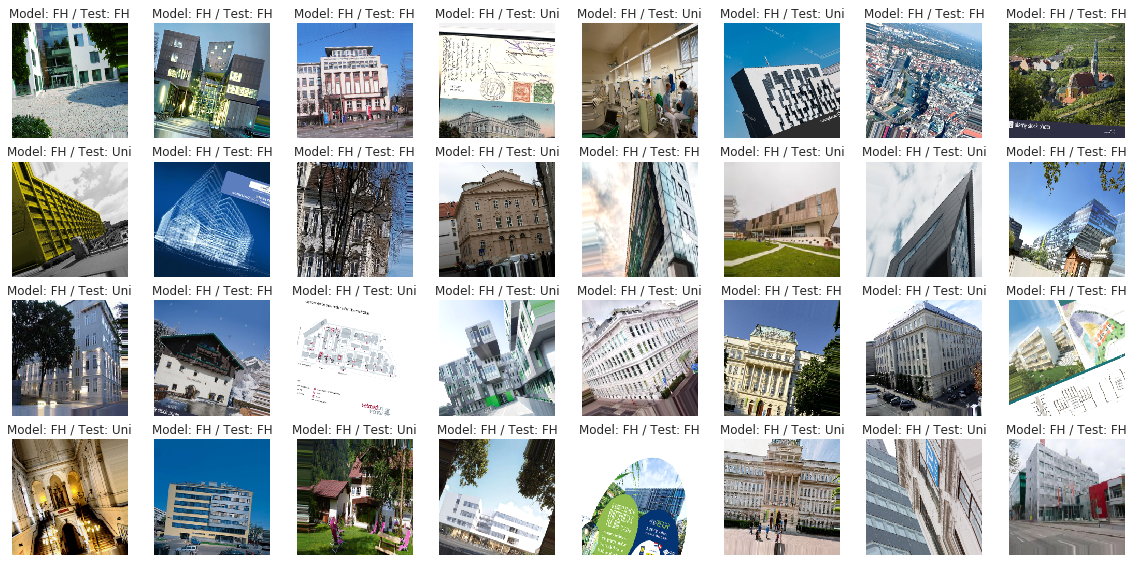

In [94]:
plt.figure(figsize=(20,20))
batch = next(skip_broken_images(train_data_gen))
for i, img in enumerate(batch[0]):
  # ResNet takes natches of images to classify so create new batch array with one image
  model_input = np.zeros((1, 224, 224, 3), dtype=float)
  model_input[0] = img

  pred = np.argmax(model_inc.predict(model_input)[0])
  test = np.argmax(batch[1][i])

  plt.subplot(8,8, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title("Model: %s / Test: %s" % (class_idx_to_name(pred), class_idx_to_name(test)))

## Observations